<a href="https://colab.research.google.com/github/iffigueroa/text-marketing-analytics/blob/main/dtsa_5799_unsupervised_text_classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Text Classification for Marketing Analytics


This project aims to perform unsupervised deep learning, on extensive e-commerce review data from Amazon. The focus is on developing topic models derived from Nike product reviews, with the goal of extracting useful insights about consumer preferences and sentiments. By utilizing both topic modeling and sentiment analysis methods, we seek to uncover what attributes people appreciate and dislike about the reviewed Nike products.

The approach involves leveraging unsupervised deep learning techniques to derive meaningful topics from the reviews. By understanding primary topics within reviews, we can identify key attributes that stand out to consumers, and by analyzing sentiment within the reviews, can pinpoint specific aspects that drive positive or negative perceptions of Nike products.

Ultimately, the goal is to provide actionable insights that could enhance understanding of consumer preferences, leading to more effective marketing strategies and the development of products that better meet consumer needs.


# Project Setup

## Imports & Installs

In [1]:
import importlib.util

if importlib.util.find_spec('numba'):
    !pip uninstall -y numba
if importlib.util.find_spec('tensorflow'):
    !pip uninstall -y tensorflow
if not importlib.util.find_spec('lda'):
    !pip install lda
if not importlib.util.find_spec('tmtoolkit'):
    !pip install "tmtoolkit[recommended]"

In [2]:
from textblob import TextBlob
from tmtoolkit.corpus import (
  Corpus,tokens_table, print_summary, lemmatize, to_lowercase, filter_for_pos, remove_chars, filter_clean_tokens,remove_common_tokens, remove_uncommon_tokens,corpus_num_tokens, corpus_tokens_flattened,dtm, vocabulary
)
from tmtoolkit.bow.bow_stats import doc_lengths
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words, ldamodel_top_doc_topics
from tmtoolkit.topicmod.tm_lda import compute_models_parallel
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words
from tmtoolkit.topicmod.visualize import parameters_for_ldavis
import numpy as np
from string import punctuation
import json
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import re


## Extracting the Data

Before we can get started, I'll start by loading and extracting the relevant data from the dataset. For this project I was provided with two json files with review product reviews and their metadata, that I have stored in a Google drive. In the section below I load both json files, and only reviews and metadata associated with Nike product reviews.

I start by loading the metadata, and capturing ASIN ids related to Nike products, then I load the reviews, and extract reviews related to those ASIN ids.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/2_topic_modeling"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
if 'nike_asins' not in locals():
  nike_asins = []
  print("Finding Nike ASINs...")
  with open(f"{path}/meta_Clothing_Shoes_and_Jewelry.jsonl") as products:
      for product in products:
          data = json.loads(product)
          categories = [c.lower() for c in
                        list(itertools.chain(*data.get("categories", [])))]
          if "nike" in categories:
            if (data.get("salesRank") and "Shoes" in data['salesRank'].keys()):
              nike_asins.append((data["asin"]))


Finding Nike ASINs...


In [5]:
len(f"There are {nike_asins} ids within this dataset.")

92421

In [6]:
if 'nike_reviews' not in locals():
  print("Finding Nike Shoe Reviews...")
  review_text = []
  ratings = []
  with open(f"{path}/reviews_Clothing_Shoes_and_Jewelry_5.json") as reviews:
      for review in reviews:
          data = json.loads(review)
          if data["asin"] in nike_asins:
              review_text.append(data['summary'] +" "+data["reviewText"])
              ratings.append(data['overall'])
  nike_reviews = pd.DataFrame({
      "review": review_text,
      'rating': ratings
  })


Finding Nike Shoe Reviews...


In [7]:
print(f"Found {len(nike_reviews)} Nike reviews.\n")
print("Some example reviews:")
nike_reviews.head()

Found 303 Nike reviews.

Some example reviews:


,review,rating
0,"Quality Shoe I wear a size 10.5&#34; shoe, ord...",5.0
1,"super light, great running shoe fits perfectly...",5.0
2,Great running shoe This shoe is very light and...,5.0
3,Very good shoes As always this shoes were what...,4.0
4,"Great! These shoes were shipped quickly, came ...",5.0



## Performing Topic Modeling

Identify Nike’s product ASINS and extract the relevant reviews, you’ll need to perform topic modeling on the text of the review data. Using one of the popular clustering methods demonstrated in class (e.g., k-means or LDA), perform topic modeling on the data to reveal the most popular topics.

Visualize those topics. From a grade standpoint, we’ll be looking particularly at how logical the topic models are. Can we read them and generally understand what the topic model represents? There is no minimum or maximum of topics, instead I want you to tweak this parameter until the topics make the most sense to you.




In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stopwordsset = set(stopwords.words("english"))
stopwordsset.add('nike')
stopwordsset.add('get')
stopwordsset.add('shoe')
stopwordsset.add('try')
stopwordsset.add('use')
stopwordsset.add('say')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
def build_corpus(texts, lang="en"):
  """
  Build and preprocess a corpus, include:
  - lemmatization, text case normalization, punctuation/number/empty string removal
  - removal of common/uncommon across document tokens
  Returns processed corpus and addociated text.
  """
  corpus = Corpus({ i:r for i, r in enumerate(texts) }, language=lang)
  lemmatize(corpus, inplace=True)
  to_lowercase(corpus, inplace=True)
  remove_chars(corpus, chars=punctuation, inplace=True)
  filter_clean_tokens(corpus, remove_shorter_than=3, remove_empty=True, remove_numbers=True, remove_stopwords=stopwordsset, inplace=True)
  filter_for_pos(corpus, search_pos=['N', 'ADJ'], inplace = True)
  remove_common_tokens(corpus, df_threshold=0.95)
  remove_uncommon_tokens(corpus, df_threshold=0.001)

  processed_texts = [corpus[i] for i in range(len(texts))]
  return corpus, processed_texts

reviews_corpus, processed_texts = build_corpus(nike_reviews['review'])

In [10]:
print_summary(reviews_corpus)


Corpus with 303 documents in English
> 0 (26 tokens): quality size insole bit different company arch sup...
> 1 (28 tokens): super light great high arch narrow foot material g...
> 2 (4 tokens): great light comfortable size
> 3 (6 tokens): good confortable good quality thing ligth
> 4 (6 tokens): great box cool swoosh dark happy
> 5 (41 tokens): happy quick shipping idea type athletic size probl...
> 6 (9 tokens): nice wide toe box son wide foot wide pair
> 7 (11 tokens): excellent nice price excellent show question nice ...
> 8 (10 tokens): nice sneaker sneaker lightweight fit flaw complain...
> 9 (14 tokens): run small runs small whole size big order small ba...
(and 293 more documents)
total number of tokens: 4156 / vocabulary size: 1051


In [11]:
tokens_table(reviews_corpus)


,doc,position,token,is_punct,is_stop,lemma,like_num,pos,tag
0,0,0,quality,False,False,Quality,False,PROPN,NNP
1,0,1,size,False,False,size,False,NOUN,NN
2,0,2,insole,False,False,insole,False,NOUN,NNS
3,0,3,bit,False,False,bit,False,NOUN,NN
4,0,4,different,False,False,different,False,ADJ,JJ
...,...,...,...,...,...,...,...,...,...
4151,302,13,durable,False,False,durable,False,ADJ,JJ
4152,302,14,quality,False,False,quality,False,NOUN,NN
4153,302,15,stylish,False,False,stylish,False,ADJ,JJ
4154,302,16,good,False,False,good,False,ADJ,JJ


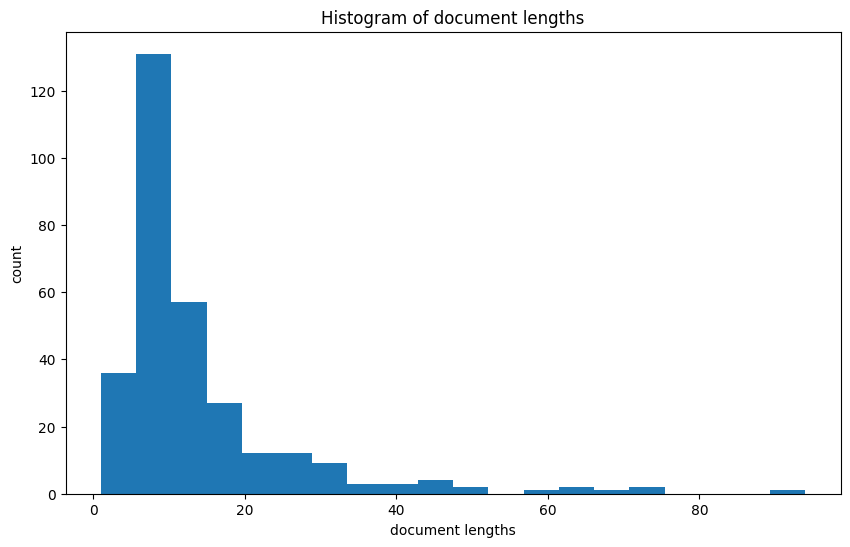

In [12]:
from tmtoolkit.corpus.visualize import (plot_doc_lengths_hist,
    plot_doc_frequencies_hist, plot_ranked_vocab_counts)
fig, ax = plt.subplots(figsize=(10, 6))   # make the plot larger
plot_doc_lengths_hist(fig, ax, reviews_corpus, y_log=False, bins=20)  # use 20 bins
plt.show();

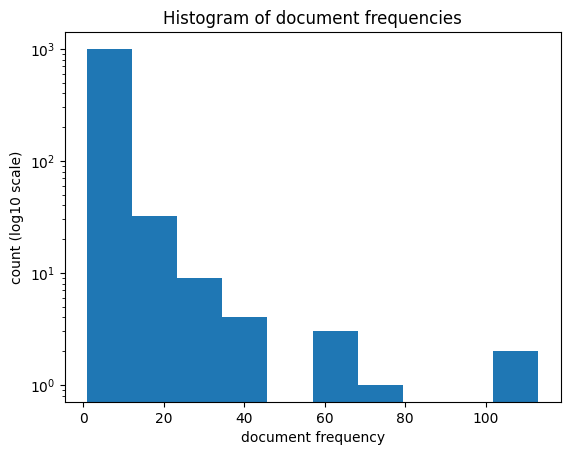

In [13]:
fig, ax = plt.subplots()
plot_doc_frequencies_hist(fig, ax, reviews_corpus)
plt.show();

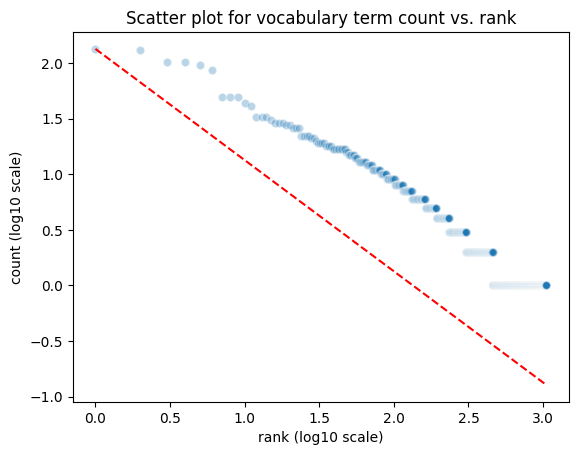

In [14]:
fig, ax = plt.subplots()
plot_ranked_vocab_counts(fig, ax, reviews_corpus, zipf=True)
plt.show();

In [15]:
vocab = vocabulary(reviews_corpus)
dtm = dtm(reviews_corpus)
doc_labels = reviews_corpus.doc_labels

In [16]:
dtm.shape

(303, 1051)

In [17]:

len(doc_labels)

303

In [18]:
dtms = {
    "reviews_corpus": dtm
}


# Evaluate alpha/n_topics

In [19]:
from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter
from tmtoolkit.topicmod.visualize import plot_eval_results

def evaluate_model(dtms, param_name, constant_params, varying_params = None):
  print(f"{len(varying_params)} parameter sets to test.")
  models = compute_models_parallel(dtms, constant_parameters=constant_params, varying_parameters=varying_params)
  eval_results = evaluate_topic_models(
    dtms['reviews_corpus'],
    varying_parameters=varying_params,
    constant_parameters=constant_params,
  )
  print(eval_results[0:5])

  # Plot the evaluation results
  results_by_n_topics = results_by_parameter(eval_results, param_name)
  plot_eval_results(results_by_n_topics)


In [20]:
# Here we can do some hyperparameter tuning/evaluation
lda_constant_params = {
    'n_iter': 100,
    'random_state': 555,
}

10 parameter sets to test.


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[({'n_topics': 1, 'alpha': 1.0, 'eta': 0.1, 'n_iter': 100, 'random_state': 555}, {'cao_juan_2009': nan, 'coherence_mimno_2011': -392.29914669049253}), ({'n_topics': 6, 'alpha': 0.16666666666666666, 'eta': 0.1, 'n_iter': 100, 'random_state': 555}, {'cao_juan_2009': 0.23256745149104172, 'coherence_mimno_2011': -394.6823042932571}), ({'n_topics': 11, 'alpha': 0.09090909090909091, 'eta': 0.1, 'n_iter': 100, 'random_state': 555}, {'cao_juan_2009': 0.17473952720344696, 'coherence_mimno_2011': -373.1316652855476}), ({'n_topics': 16, 'alpha': 0.0625, 'eta': 0.1, 'n_iter': 100, 'random_state': 555}, {'cao_juan_2009': 0.16884558505513586, 'coherence_mimno_2011': -345.91499190676404}), ({'n_topics': 21, 'alpha': 0.047619047619047616, 'eta': 0.1, 'n_iter': 100, 'random_state': 555}, {'cao_juan_2009': 0.15728893494581458, 'coherence_mimno_2011': -322.9112830917594})]


/usr/local/lib/python3.10/dist-packages/tmtoolkit/topicmod/visualize.py:833: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(**subplots_adjust_kwargs)


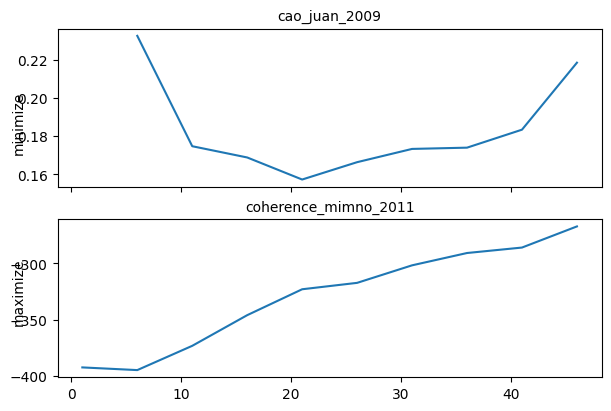

In [21]:
lda_varying_params_low_alpha = [
  {
    'n_topics': k,
    'alpha': 1/k,
    'eta': 0.1
  } for k in range(1, 50, 5)
]


evaluate_model(dtms, 'n_topics', lda_constant_params, lda_varying_params_low_alpha)

10 parameter sets to test.


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[({'n_topics': 1, 'alpha': 0.1, 'eta': 0.1, 'n_iter': 100, 'random_state': 555}, {'cao_juan_2009': nan, 'coherence_mimno_2011': -392.29914669049253}), ({'n_topics': 6, 'alpha': 0.016666666666666666, 'eta': 0.1, 'n_iter': 100, 'random_state': 555}, {'cao_juan_2009': 0.4219384316366025, 'coherence_mimno_2011': -387.12482157147906}), ({'n_topics': 11, 'alpha': 0.00909090909090909, 'eta': 0.1, 'n_iter': 100, 'random_state': 555}, {'cao_juan_2009': 0.33348948815708745, 'coherence_mimno_2011': -369.98178053129783}), ({'n_topics': 16, 'alpha': 0.00625, 'eta': 0.1, 'n_iter': 100, 'random_state': 555}, {'cao_juan_2009': 0.3073550554519438, 'coherence_mimno_2011': -379.132197593349}), ({'n_topics': 21, 'alpha': 0.004761904761904762, 'eta': 0.1, 'n_iter': 100, 'random_state': 555}, {'cao_juan_2009': 0.2532397507944856, 'coherence_mimno_2011': -339.24962399386163})]


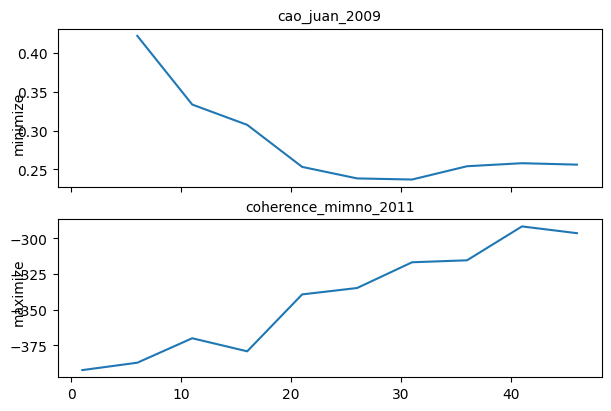

In [22]:
lda_varying_params_high_alpha = [
  {
    'n_topics': k,
    'alpha': 1/(10*k),
    'eta': 0.1
  } for k in range(1, 50, 5)
]

evaluate_model(dtms, 'n_topics', lda_constant_params, lda_varying_params_high_alpha)

# Evaluate by Beta

In [23]:
k = 25 # chosen in above analysis

lda_constant_params['n_topics'] = k
lda_constant_params['alpha'] = 1/k

lda_varying_params_eta = [
  {
    'eta': x/100,
  } for x in range(1, 50, 1)
]

49 parameter sets to test.
[({'eta': 0.01, 'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.04}, {'cao_juan_2009': 0.07558218673837226, 'coherence_mimno_2011': -341.26968602830993}), ({'eta': 0.02, 'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.04}, {'cao_juan_2009': 0.08620213065292973, 'coherence_mimno_2011': -340.5743094843632}), ({'eta': 0.03, 'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.04}, {'cao_juan_2009': 0.09612751944040035, 'coherence_mimno_2011': -340.0380662871563}), ({'eta': 0.04, 'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.04}, {'cao_juan_2009': 0.10922591465309367, 'coherence_mimno_2011': -346.7751278461941}), ({'eta': 0.05, 'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.04}, {'cao_juan_2009': 0.11227370822155215, 'coherence_mimno_2011': -335.84844804727})]


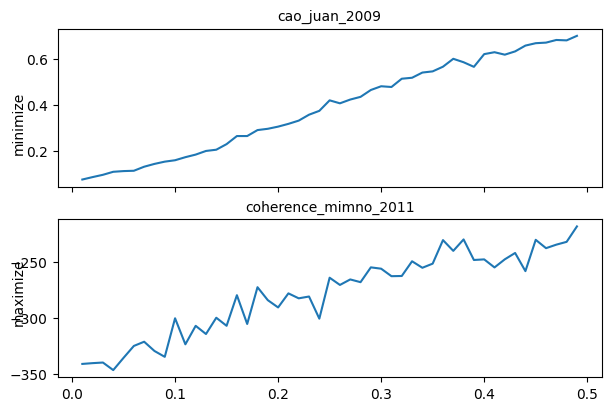

In [24]:
evaluate_model(dtms, 'eta', lda_constant_params, lda_varying_params_eta)

49 parameter sets to test.
[({'eta': 0.02, 'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.004}, {'cao_juan_2009': 0.1647675744067143, 'coherence_mimno_2011': -363.41178571725146}), ({'eta': 0.01, 'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.004}, {'cao_juan_2009': 0.13311127809319584, 'coherence_mimno_2011': -360.9561654374938}), ({'eta': 0.04, 'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.004}, {'cao_juan_2009': 0.18628571177099185, 'coherence_mimno_2011': -350.81872399708436}), ({'eta': 0.03, 'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.004}, {'cao_juan_2009': 0.16954882364600762, 'coherence_mimno_2011': -347.52935797233613}), ({'eta': 0.05, 'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.004}, {'cao_juan_2009': 0.2060802602778449, 'coherence_mimno_2011': -353.00187735103674})]


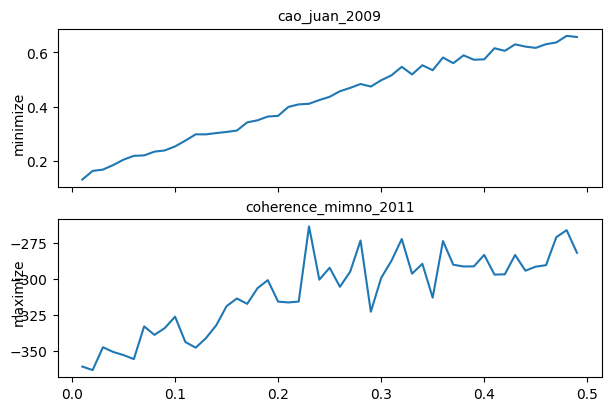

In [25]:
lda_constant_params['alpha'] = 1/(10*k)
evaluate_model(dtms, 'eta', lda_constant_params, lda_varying_params_eta)

# Continue with best model

In [26]:
# Pick best model to continue with
beta = 0.05
lda_constant_params['eta'] = beta
# lda_constant_params['alpha'] = 1/(10*k)
lda_constant_params['alpha'] = 1/k
print(lda_constant_params)
models = compute_models_parallel(dtms, constant_parameters=lda_constant_params)

model = models["reviews_corpus"][0][1]
print_ldamodel_topic_words(model.topic_word_, vocabulary(reviews_corpus), top_n=5)

{'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.04, 'eta': 0.05}
topic_1
> #1. size (0.119345)
> #2. foot (0.056042)
> #3. good (0.048594)
> #4. tight (0.044871)
> #5. fit (0.044871)
topic_2
> #1. size (0.139235)
> #2. sneaker (0.065631)
> #3. color (0.061542)
> #4. half (0.041096)
> #5. big (0.028828)
topic_3
> #1. sandal (0.109998)
> #2. comfortable (0.081365)
> #3. little (0.043188)
> #4. foot (0.043188)
> #5. summer (0.024099)
topic_4
> #1. great (0.137237)
> #2. good (0.080614)
> #3. price (0.065713)
> #4. comfortable (0.053792)
> #5. nice (0.044852)
topic_5
> #1. air (0.069366)
> #2. pegasus (0.039743)
> #3. max (0.034806)
> #4. fit (0.029869)
> #5. heavy (0.024932)
topic_6
> #1. good (0.114649)
> #2. pair (0.071722)
> #3. comfortable (0.053837)
> #4. comfort (0.039528)
> #5. arch (0.028796)
topic_7
> #1. sneaker (0.065188)
> #2. comfortable (0.049895)
> #3. comfy (0.049895)
> #4. foot (0.049895)
> #5. good (0.046071)
topic_8
> #1. model (0.054014)
> #2. slipper (



## Performing Data Clustering
Once you’ve got your final topics, perform topic classification on the documents to automatically cluster your da
ta by topic. Inspect a dozen or so reviews from each topic to better understand what the topics actually represent. Make sure you print your ASIN for each review alongside the review. Look at common ASINs, and resolve those ASINs to specific products so you know what products are commonly talked about in each topic. Altogether, summarize these topics in 1-2 sentences.




EXTRA: DO sentiment analysis on the various clusters?

In [27]:
topic_labels = generate_topic_labels_from_top_words(
    model.topic_word_,
    model.doc_topic_,
    doc_lengths(dtm),
    np.array(vocab),
    n_words = 4
)

In [28]:
for topic in topic_labels:
  print(topic)

1_size_foot_good_tight
2_size_sneaker_color_half
3_sandal_comfortable_little_foot
4_great_good_price_comfortable
5_air_pegasus_max_fit
6_good_pair_comfortable_comfort
7_sneaker_comfortable_comfy_foot
8_model_slipper_thick_money
9_foot_wide_great_pair
10_water_excelente_como_lace
11_style_love_comfy_boyfriend
12_great_perfect_son_gift
13_time_cheap_brand_gym
14_light_running_bright_red
15_pair_price_good_comfortable
16_day_size_small_little
17_flop_flip_nice_comfortable
18_pair_little_soft_free
19_great_well_nylon_lace
20_bad_squeak_person_picture
21_product_issue_year_month
22_new_arch_great_balance
23_foot_sole_problem_pain
24_sneaker_fit_lightweight_soft
25_running_casual_purchase_sizing


In [29]:
doc_topic = model.doc_topic_
documentclassifications = ldamodel_top_doc_topics(doc_topic, doc_labels, top_n=3, topic_labels=topic_labels)

In [30]:
ldavis_params = parameters_for_ldavis(
    model.topic_word_,
    model.doc_topic_,
    dtm,
    vocab
)

In [31]:
try:
  import pyLDAvis
except:
  !pip install pyLDAvis==2.1.2
  import pyLDAvis

In [32]:
%matplotlib inline
vis = pyLDAvis.prepare(**ldavis_params)
pyLDAvis.enable_notebook(local=True)
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  head(R).drop('saliency', 1)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: Deprecat

# Analyzing Negative Reviews

In [33]:
def get_text_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    if polarity > 0:
        if subjectivity > 0.5:
            return "Positive"
        else:
            return "Neutral"
    elif polarity < 0:
        if subjectivity > 0.5:
            return "Negative"
        else:
            return "Neutral"
    else:
        return "Neutral"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
documentclassifications["full_text"] = nike_reviews['review']
documentclassifications['processed_text'] = [text['token'] for text in processed_texts]
documentclassifications['sentiment'] = documentclassifications['full_text'].apply(get_text_sentiment)
documentclassifications['rating'] = nike_reviews['rating']
documentclassifications.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,rank_1,rank_2,rank_3,full_text,processed_text,sentiment,rating
document,,,,,,,
0,22_new_arch_great_balance (0.52),19_great_well_nylon_lace (0.2237),1_size_foot_good_tight (0.1496),"Quality Shoe I wear a size 10.5&#34; shoe, ord...","[quality, size, insole, bit, different, compan...",Positive,5.0
1,9_foot_wide_great_pair (0.3807),6_good_pair_comfortable_comfort (0.3117),12_great_perfect_son_gift (0.1393),"super light, great running shoe fits perfectly...","[super, light, great, high, arch, narrow, foot...",Neutral,5.0
2,16_day_size_small_little (0.608),14_light_running_bright_red (0.208),25_running_casual_purchase_sizing (0.008),Great running shoe This shoe is very light and...,"[great, light, comfortable, size]",Positive,5.0
3,4_great_good_price_comfortable (0.4343),7_sneaker_comfortable_comfy_foot (0.4343),25_running_casual_purchase_sizing (0.005714),Very good shoes As always this shoes were what...,"[good, confortable, good, quality, thing, ligth]",Positive,4.0
4,1_size_foot_good_tight (0.2914),12_great_perfect_son_gift (0.2914),16_day_size_small_little (0.1486),"Great! These shoes were shipped quickly, came ...","[great, box, cool, swoosh, dark, happy]",Positive,5.0
5,15_pair_price_good_comfortable (0.3819),23_foot_sole_problem_pain (0.3343),16_day_size_small_little (0.2152),Happy for quick shipping I alredy had an idea ...,"[happy, quick, shipping, idea, type, athletic,...",Neutral,4.0
6,9_foot_wide_great_pair (0.804),12_great_perfect_son_gift (0.104),25_running_casual_purchase_sizing (0.004),Nice wide toe box! My son has extremely wide f...,"[nice, wide, toe, box, son, wide, foot, wide, ...",Neutral,5.0
7,4_great_good_price_comfortable (0.7533),15_pair_price_good_comfortable (0.17),25_running_casual_purchase_sizing (0.003333),"Excellent Shoe Nice price, excellent show I lo...","[excellent, nice, price, excellent, show, ques...",Positive,5.0
8,24_sneaker_fit_lightweight_soft (0.4582),4_great_good_price_comfortable (0.2764),17_flop_flip_nice_comfortable (0.1855),Nice sneakers These sneakers are exactly as th...,"[nice, sneaker, sneaker, lightweight, fit, fla...",Positive,5.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1200x800 with 0 Axes>

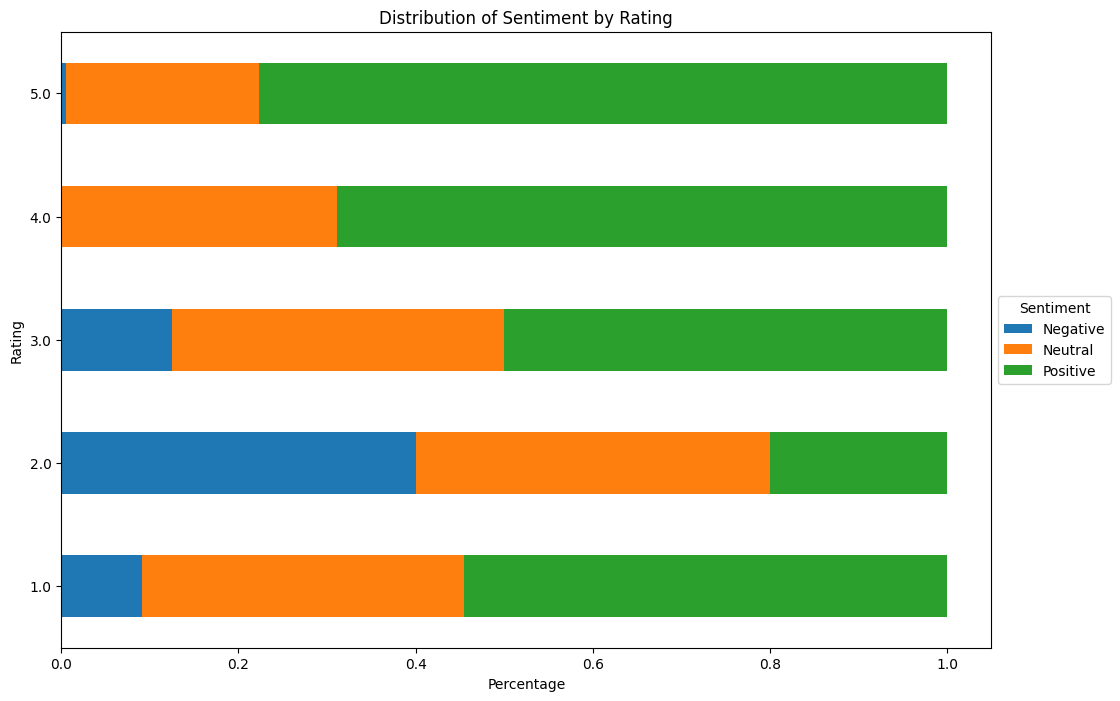

In [35]:
sentiment_counts = documentclassifications.groupby(['rating', 'sentiment']).size().unstack(fill_value=0)
normalized_sentiment_counts = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

plt.figure(figsize=(12, 8))
normalized_sentiment_counts.plot(kind='barh', stacked=True, figsize=(12, 8))
plt.xlabel('Percentage')
plt.ylabel('Rating')
plt.title('Distribution of Sentiment by Rating')
plt.legend(title='Sentiment', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [36]:
# Update Sentiment to be by rating instead
def get_sentiment_by_rating(rating):
  if rating <= 3:
    return "Negative"
  return "Positive"

documentclassifications['sentiment'] = documentclassifications['rating'].apply(get_sentiment_by_rating)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-37-cad23346b204>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  documentclassifications['rank_1_clean'] = documentclassifications['rank_1'].str.replace(r'\s*\([^()]*\)', '')


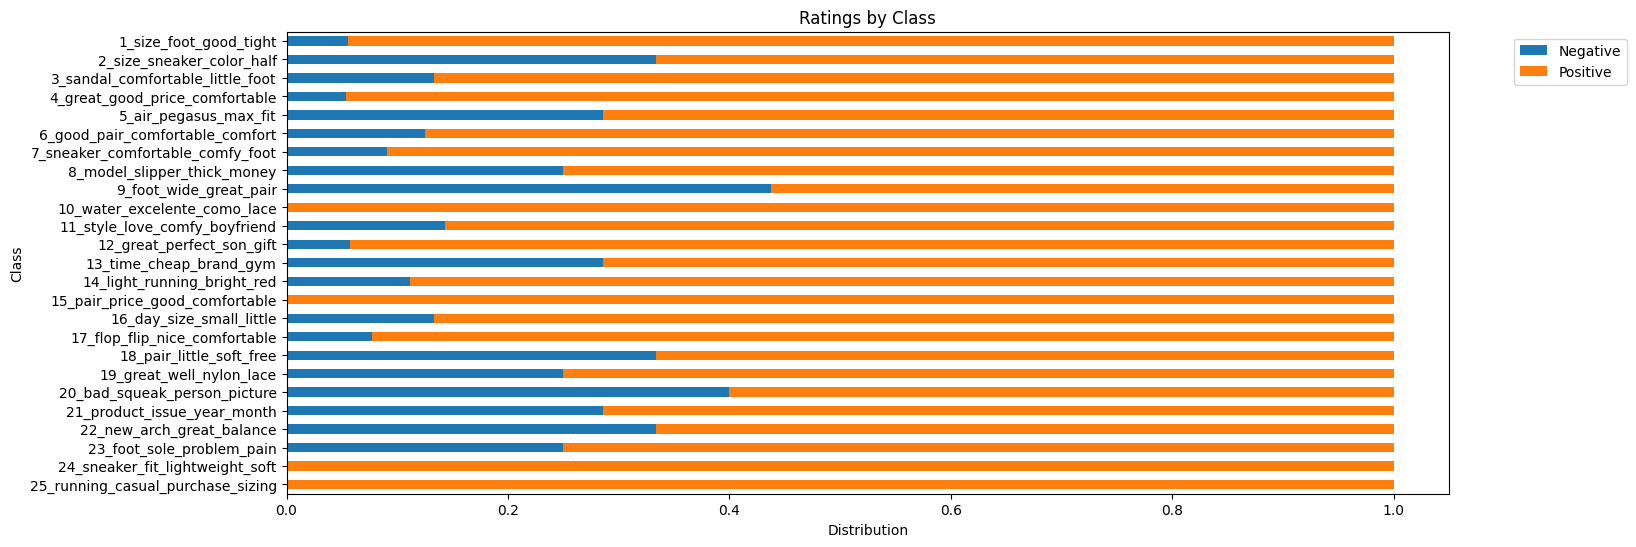

In [37]:
documentclassifications['rank_1_clean'] = documentclassifications['rank_1'].str.replace(r'\s*\([^()]*\)', '')
documentclassifications.head()

sentiment_counts = documentclassifications.groupby(['rank_1_clean', 'sentiment']).size().unstack(fill_value=0)
normalized_sentiment_counts = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)
def sort_by_numerical_prefix(s):
    # Extract numerical part of the string
    numerical_part = re.match(r'^(\d+)', s).group(1)
    return int(numerical_part)
sorted = normalized_sentiment_counts.sort_values(by='rank_1_clean', ascending=False,  key=lambda x: x.map(sort_by_numerical_prefix))
sorted.plot(kind='barh', stacked=True, figsize=(15, 6))
plt.ylabel('Class')
plt.xlabel('Distribution')
plt.title('Ratings by Class')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [38]:
negative_topics = list(normalized_sentiment_counts[normalized_sentiment_counts['Negative'] >= 0.25].index.unique())
negative_topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['13_time_cheap_brand_gym',
 '18_pair_little_soft_free',
 '19_great_well_nylon_lace',
 '20_bad_squeak_person_picture',
 '21_product_issue_year_month',
 '22_new_arch_great_balance',
 '23_foot_sole_problem_pain',
 '2_size_sneaker_color_half',
 '5_air_pegasus_max_fit',
 '8_model_slipper_thick_money',
 '9_foot_wide_great_pair']

In [40]:
def get_reviews_to_print(df):
  if df.shape[0] != 0:
    data = df.head().tolist()
    if not all(isinstance(item, str) for item in data):
      data = [str(item) for item in data]
    return "\n".join(data)
  return "N/A"
all_sentiments = documentclassifications['sentiment'].unique()

def print_sample_reviews(sentiments, data):
  print("----------------------------------------")
  print(f"Classification [{topic}]")
  print("----------------------------------------")
  for sentiment in sentiments:
    sentiment_data = data.loc[(filtered['sentiment'] == sentiment), 'full_text']
    sentiment_texts = get_reviews_to_print(sentiment_data)
    print(f"[Sample {sentiment} Reviews")
    print(f"{sentiment_texts}\n")

for topic in negative_topics:
    filtered = documentclassifications[(documentclassifications['rank_1_clean'] == topic)]
    print_sample_reviews(['Negative'], filtered)



----------------------------------------
Classification [13_time_cheap_brand_gym]
----------------------------------------
[Sample Negative Reviews
HARD CHEAP PLASTIC BOTTOM AND THE TOP IS UNGLUED FROM THE BOTTOM ON ONE SIDE WHEN I GOT THEM. HARD CHEAP PLASTIC BOTTOM AND THE TOP IS UNGLUED FROM THE BOTTOM ON ONE SIDE WHEN I GOT THEM. If it wasn't such a pain in the rear to return stuff these would be going back. They will do for my husband until the strap comes completely unglued. These are NOTHING like the Benassi slides that Nike had before.
Almost Returned I bought Nike Pegasus 29 for my daughter over a year ago for Christmas (from a different site).  We usually wear the same size and since I have a hard time finding a comfortable sneaker I decided to try hers and thought they were really &#34;cushy&#34; but decided to go up a half size (hers are 7 1/2, I ordered an 8) just because it felt a little short for my big toe.  The 8 didn't really seem to make much difference in these, eve

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Insights & Conclusions



# References
- https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews
- https://tmtoolkit.readthedocs.io/en/latest/index.html

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
